In [ ]:
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<h1>Exploratory Data Analysis</h1>

In [ ]:
pop = pd.read_csv("https://raw.githubusercontent.com/NUS-BACT/datasets/master/Heart_Disease_Prediction.csv")

pop.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [ ]:
pop.isna().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

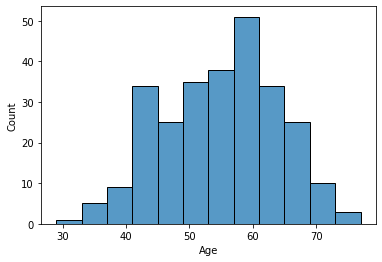

In [ ]:
#Plotting age distribution
sns.histplot(data=pop, x="Age")

<AxesSubplot:xlabel='Sex', ylabel='count'>

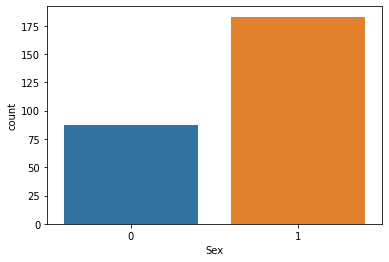

In [ ]:
#Plotting sex distribution
sns.countplot(data=pop, x="Sex")

<AxesSubplot:xlabel='Heart Disease', ylabel='count'>

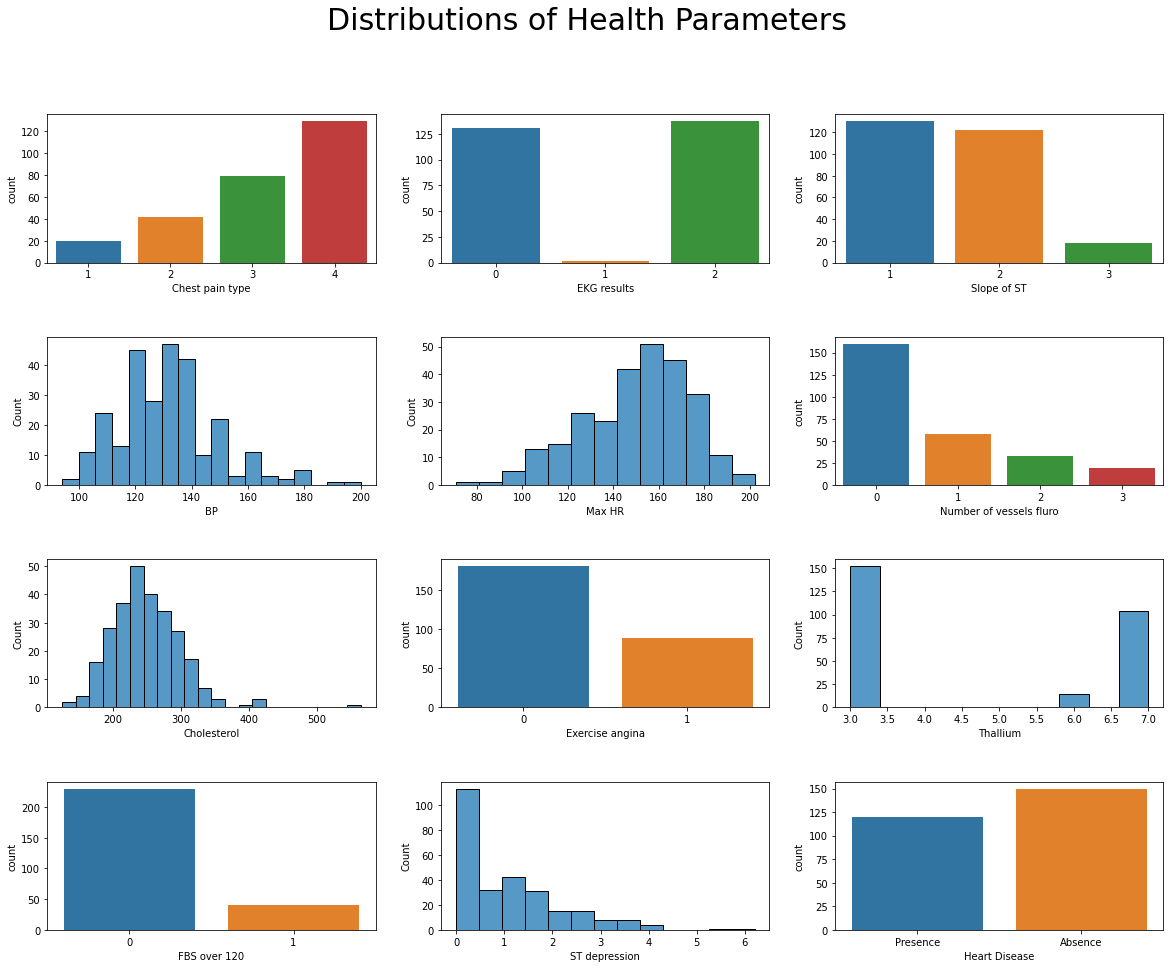

In [ ]:
fig, axes = plt.subplots(4, 3, sharex=False, figsize=(20,15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Health Parameters', fontsize=30)

#Chest pain type
sns.countplot(ax=axes[0, 0], data=pop, x="Chest pain type")

#BP
sns.histplot(ax=axes[1, 0], data=pop, x="BP")

#Cholesterol
sns.histplot(ax=axes[2, 0], data=pop, x="Cholesterol")

#FBS over 120 (binary variable) - fasting blood sugar
sns.countplot(ax=axes[3, 0], data=pop, x="FBS over 120")

#EKG results
sns.countplot(ax=axes[0, 1], data=pop, x="EKG results")

#Max HR
sns.histplot(ax=axes[1, 1], data=pop, x="Max HR")

#Exercise angina
sns.countplot(ax=axes[2, 1], data=pop, x="Exercise angina")

#ST depression
sns.histplot(ax=axes[3, 1], data=pop, x="ST depression")

#Slope of ST
sns.countplot(ax=axes[0, 2], data=pop, x="Slope of ST")

#Number of vessels fluro
sns.countplot(ax=axes[1, 2], data=pop, x="Number of vessels fluro")

#Thallium
sns.histplot(ax=axes[2, 2], data=pop, x="Thallium")

#Heart disease
sns.countplot(ax=axes[3, 2], data=pop, x="Heart Disease")

<h1>Train-Test Split</h1>

In [ ]:
df = pop.copy()

#Set "Heart Disease" as the y variable
y = df["Heart Disease"]

#Set everything other than Heart Disease as the X variables
X = df.drop(columns=["Heart Disease"])

#Train test split in a 80:20 ratio, with a random state for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h1>Logistic Regression</h1>

<h2>Feature Encoding (One-Hot Encoding)</h2>

In [ ]:
#get list of all categorical variables
categorical_variables = []

for column in X_train.columns:
    if df[column].dtype == "object":
        categorical_variables.append(column)
    
print("Categorical variables: ", categorical_variables) #No categorical dependent variables

#One-hot encoding, fitted on the train dataset
enc_lr = OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore")

transformer_lr = ColumnTransformer([
    ("categorical", enc_lr, categorical_variables)
], remainder="passthrough")

Categorical variables:  []


<h2>Pipeline</h2>

In [ ]:
lr = LogisticRegression(max_iter=10000, solver="liblinear", penalty="l1")

pipeline_lr = Pipeline(steps=[("transformer", transformer_lr), ("scaler", StandardScaler()), ('pca', PCA()), ("logistic", lr)])


<h2>Cross Validation</h2>

In [ ]:
def show_cv_results(pipeline):
    scores = cross_validate(pipeline, X_train, y_train, cv=10, return_train_score=True)
    print("Mean test score: ", scores["test_score"].mean())
    display(pd.DataFrame(scores))
    
show_cv_results(pipeline_lr)

Mean test score:  0.8142857142857143


,fit_time,score_time,test_score,train_score
0,0.027988,0.002686,0.772727,0.855670
1,0.003815,0.001837,0.727273,0.881443
2,0.003996,0.001851,0.772727,0.845361
3,0.003784,0.001939,0.863636,0.850515
4,0.003876,0.001911,0.954545,0.835052
5,0.003933,0.001948,0.909091,0.840206
6,0.003891,0.002110,0.761905,0.841026
7,0.003779,0.001876,0.857143,0.841026
8,0.003797,0.001909,0.714286,0.851282
9,0.003846,0.001924,0.809524,0.841026


<h2>Hyperparameter Tuning</h2>

In [ ]:
n_components = list(range(1, X.shape[1]+1, 1))
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(logistic__C=C,
                  logistic__penalty=penalty,
                  pca__n_components=n_components)

gs_lr = GridSearchCV(pipeline_lr, parameters)
gs_lr.fit(X_train, y_train)

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    print('Best penalty: ', gs.best_estimator_.get_params()['logistic__penalty'], "\n")
    print('Best number of components: ', gs.best_estimator_.get_params()['pca__n_components'], "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))    
    
    
report_GridSearchCV_results(gs_lr)

Best combination of hyperparams:
 {'logistic__C': 0.040949150623804234, 'logistic__penalty': 'l2', 'pca__n_components': 11} 

Best mean_test_score score:
 0.8335095137420719 

Score by fold for best estimator:
 [0.7954545454545454, 0.8372093023255814, 0.9302325581395349, 0.813953488372093, 0.7906976744186046] 

Best penalty:  l2 

Best number of components:  11 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_logistic__C,param_logistic__penalty,param_pca__n_components
rank_test_score,,,,
1,0.83351,0.086851,l2,11
1,0.83351,0.040949,l2,11
1,0.83351,0.26827,l2,11
1,0.83351,0.059636,l2,12
1,0.83351,0.059636,l2,11


<h2>Performance on Test Set</h2>

              precision    recall  f1-score   support

     Absence       0.89      0.97      0.93        33
    Presence       0.94      0.81      0.87        21

    accuracy                           0.91        54
   macro avg       0.92      0.89      0.90        54
weighted avg       0.91      0.91      0.91        54



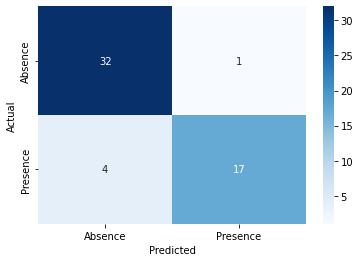

In [ ]:
def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))
    
    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
score_model(gs_lr, X_test, y_test)

# Random Forest Classifier

In [ ]:
#get list of all categorical variables
categorical_variables = []

for column in X_train.columns:
    if df[column].dtype == "object":
        categorical_variables.append(column)
    
print("Categorical variables: ", categorical_variables) #No categorical dependent variables

#One-hot encoding, fitted on the train dataset
enc_rf = OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore")

transformer_rf = ColumnTransformer([
    ("categorical", enc_rf, categorical_variables)
], remainder="passthrough")

Categorical variables:  []


In [ ]:
rf = RandomForestClassifier(bootstrap = True, max_depth = 60, n_estimators = 60, random_state = 42)

pipeline_rf = Pipeline(steps=[("transformer", transformer_rf), ("scaler", StandardScaler()), ('pca', PCA()), ("randomforest", rf)])

## Cross Validation

In [ ]:
show_cv_results(pipeline_rf)

Mean test score:  0.8244588744588744


,fit_time,score_time,test_score,train_score
0,0.103564,0.007937,0.818182,1.0
1,0.094180,0.007794,0.681818,1.0
2,0.095928,0.007797,0.772727,1.0
3,0.094724,0.011622,0.818182,1.0
4,0.095824,0.008250,0.909091,1.0
5,0.098263,0.007885,0.863636,1.0
6,0.102583,0.007821,0.809524,1.0
7,0.103645,0.010336,0.904762,1.0
8,0.097836,0.008335,0.761905,1.0
9,0.097470,0.018096,0.904762,1.0


## Hyperparameter Tuning

In [ ]:
n_components = list(range(1, X.shape[1]+1, 1))

param_grid = dict(
    randomforest__bootstrap = [True, False],
    randomforest__max_depth = [50, 60, 80],
    randomforest__n_estimators = [50, 60, 80, 100],
    pca__n_components = n_components)



gs_rf = GridSearchCV(pipeline_rf, param_grid)
gs_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [])])),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('randomforest',
                                        RandomForestClassifier(max_depth=60,
                                                               n_estimators=60,
                                         

In [ ]:
def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    
    print("Score by fold for best estimator:\n", scores, "\n")
    
    print('Bootstrap: ', gs.best_estimator_.get_params()['randomforest__bootstrap'], "\n")
    print('Best Max Depth: ', gs.best_estimator_.get_params()['randomforest__max_depth'], "\n")
    print('Best n_estimators: ', gs.best_estimator_.get_params()['randomforest__n_estimators'], "\n")
    print('Best number of components: ',  gs.best_estimator_.get_params()['pca__n_components'], "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))
    

report_GridSearchCV_results(gs_rf)

Best combination of hyperparams:
 {'pca__n_components': 12, 'randomforest__bootstrap': True, 'randomforest__max_depth': 50, 'randomforest__n_estimators': 50} 

Best mean_test_score score:
 0.8244186046511628 

Score by fold for best estimator:
 [0.75, 0.813953488372093, 0.9069767441860465, 0.8372093023255814, 0.813953488372093] 

Bootstrap:  True 

Best Max Depth:  50 

Best n_estimators:  50 

Best number of components:  12 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_randomforest__bootstrap,param_randomforest__max_depth,param_randomforest__n_estimators,param_pca__n_components
rank_test_score,,,,,
1,0.824419,True,60,60,12
1,0.824419,True,80,60,12
1,0.824419,True,80,50,12
1,0.824419,True,60,50,12
1,0.824419,True,50,50,12


              precision    recall  f1-score   support

     Absence       0.88      0.91      0.90        33
    Presence       0.85      0.81      0.83        21

    accuracy                           0.87        54
   macro avg       0.87      0.86      0.86        54
weighted avg       0.87      0.87      0.87        54



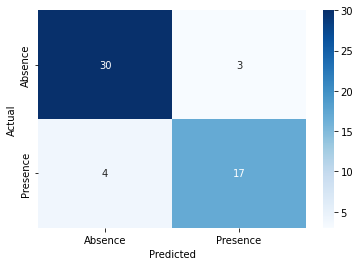

In [ ]:
score_model(gs_rf, X_test, y_test)